##  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder


## Load Dataset

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

# Optional: Combine into one DataFrame for EDA
df = X.copy()
df['target'] = y
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Exploratory Data Analysis (EDA)

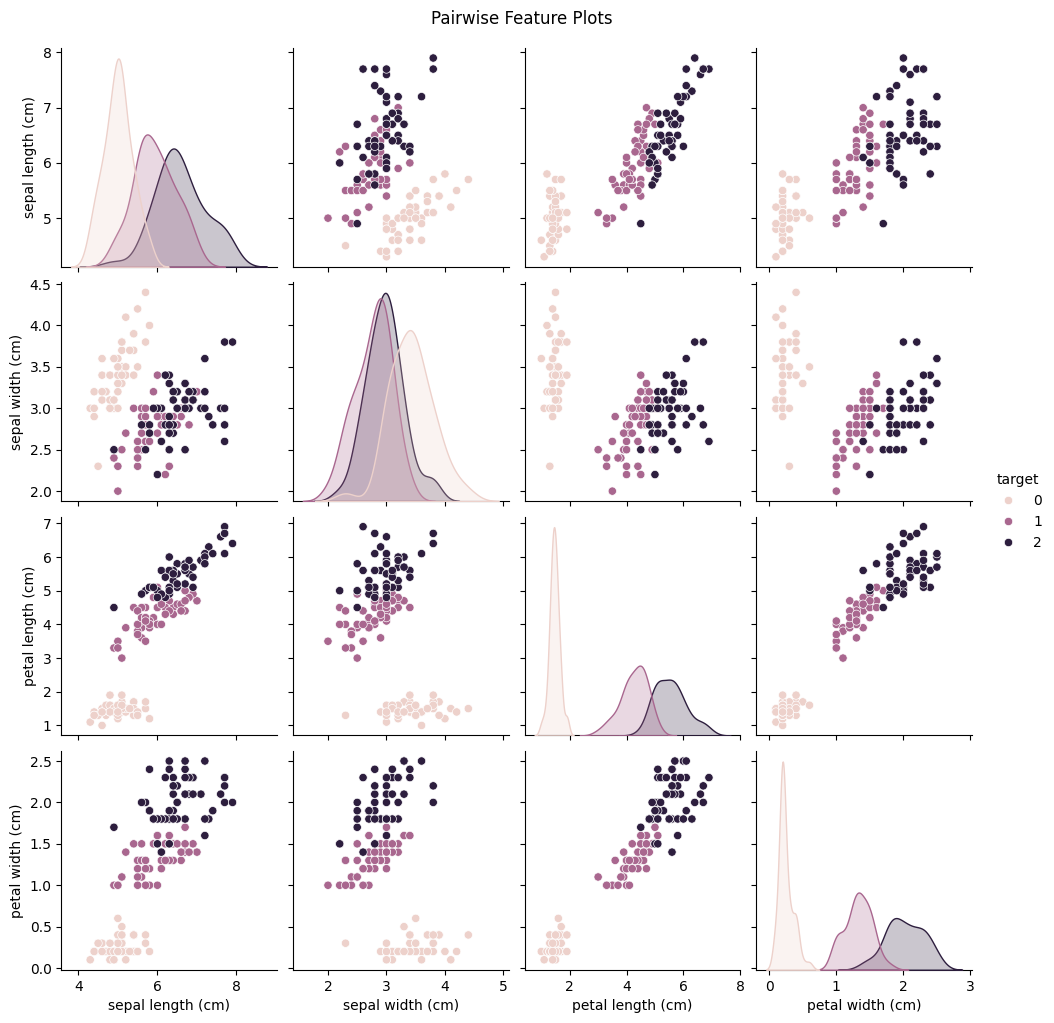

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  
target
0    50
1    50
2    50
Name: count, dtype: int64


In [3]:
sns.pairplot(df, hue='target')
plt.suptitle("Pairwise Feature Plots", y=1.02)
plt.show()

print(df.describe())
print(df['target'].value_counts())


## Feature Selection

In [4]:
# Select top k features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

# Update X with selected features (optional)
X = X[selected_features]


Selected Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


## Split the dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Train

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

##  Model Evaluation

Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



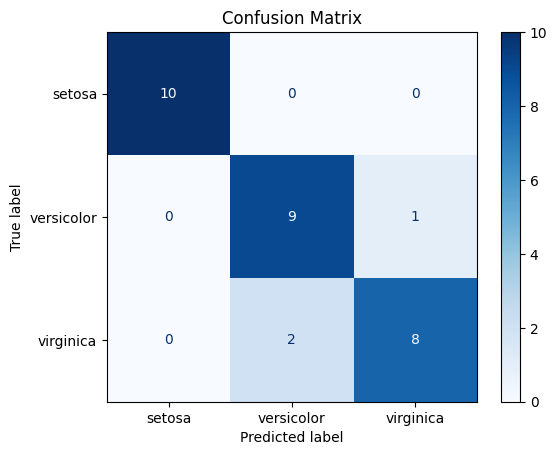

In [7]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Feature Importance Plot

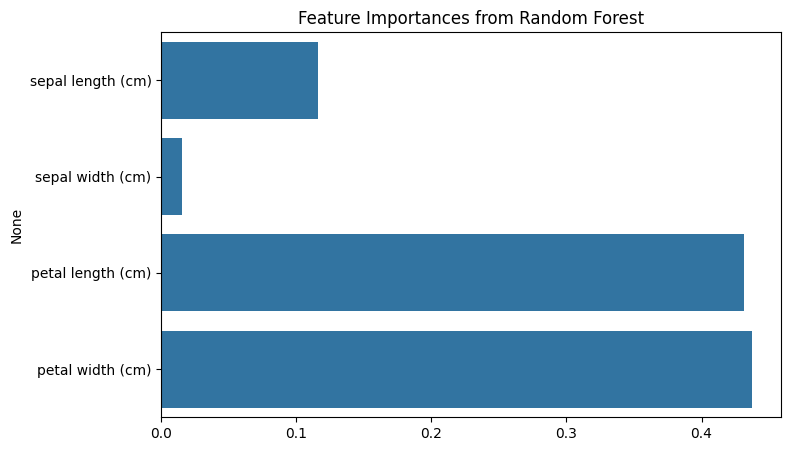

In [8]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances from Random Forest")
plt.show()


## Hyper parameter tuning with gridsearch cv

In [9]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Best CV Score: 0.975


## Evaluate Tuned Model

Tuned Model Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



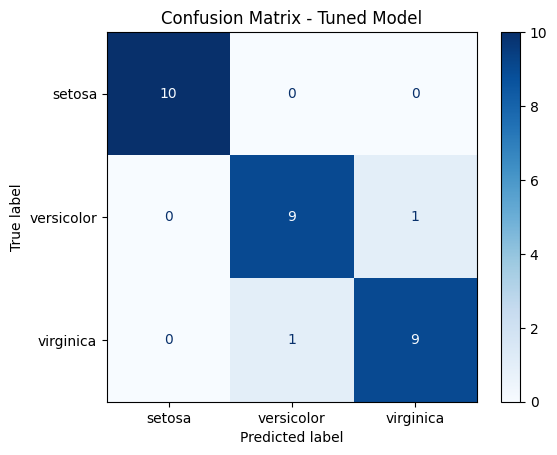

In [10]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=iris.target_names, cmap='Blues')
plt.title("Confusion Matrix - Tuned Model")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


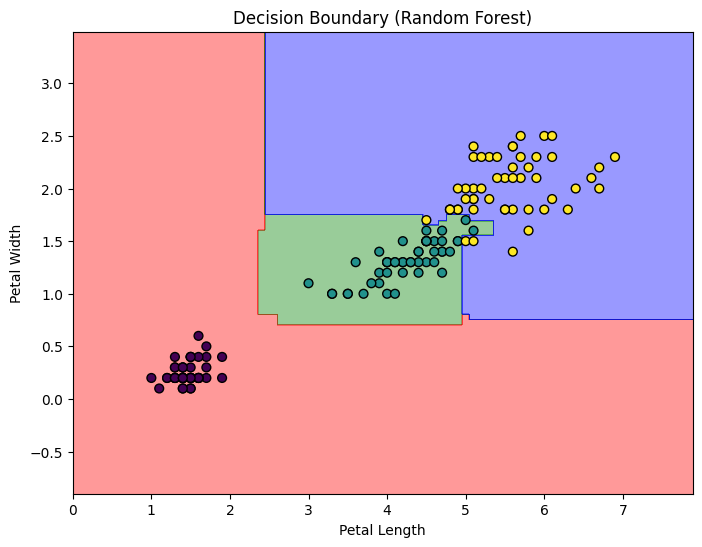

In [11]:
# If dataset has only 2 features (like using only petal_length & petal_width)
from matplotlib.colors import ListedColormap

X_vis = X[['petal length (cm)', 'petal width (cm)']]  # example
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_vis, y, test_size=0.2, random_state=42)

rf_vis = RandomForestClassifier(n_estimators=100, random_state=42)
rf_vis.fit(X_train_v, y_train_v)

x_min, x_max = X_vis.iloc[:, 0].min() - 1, X_vis.iloc[:, 0].max() + 1
y_min, y_max = X_vis.iloc[:, 1].min() - 1, X_vis.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = rf_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['red', 'green', 'blue']))
plt.scatter(X_vis.iloc[:, 0], X_vis.iloc[:, 1], c=y, s=40, edgecolor='k')
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Decision Boundary (Random Forest)")
plt.show()
